In [44]:
import xarray as xr 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
from utils.utils import Fill_NC_With_Station_Values, aggregate_per_timestep_xr, calculate_metrics
from era5.era5_cropper import Era5ForStationCropper
from train_station_twin.prepare_training_executor_era5 import TrainingPreparation



In [46]:
# Load ERA5 Data
# this covers the period 2020-2023 and is in 9x9 grid
era5 = xr.open_dataset('converted_era5_data/era5_marshall_events_202002-202304.nc')
era5.t2m.values

array([[[ -7.7952576 ,  -6.783539  ,  -5.5433044 , ...,  -0.53500366,
          -0.2749939 ,  -0.11239624],
        [ -8.470551  ,  -9.064056  ,  -7.7947693 , ...,   0.8248596 ,
           0.74990845,   0.9093323 ],
        [ -8.95932   ,  -9.654144  ,  -8.697601  , ...,   1.3705139 ,
           1.2411194 ,   1.6822815 ],
        ...,
        [-12.686127  , -11.930023  ,  -9.703949  , ...,  -0.88290405,
          -1.1619568 ,  -0.89242554],
        [-11.874603  ,  -9.726898  ,  -7.186371  , ...,  -2.210785  ,
          -1.5013123 ,  -1.1560974 ],
        [-10.115082  ,  -8.23642   ,  -7.1905212 , ...,  -0.36727905,
          -0.26254272,  -0.735199  ]],

       [[ -7.6165466 ,  -6.62973   ,  -5.3372498 , ...,  -0.717865  ,
          -0.5450134 ,  -0.4703064 ],
        [ -8.46225   ,  -8.745941  ,  -7.422943  , ...,   0.3956604 ,
           0.44961548,   0.5201721 ],
        [ -8.713959  ,  -9.081146  ,  -8.175629  , ...,   0.7489319 ,
           0.82192993,   1.271637  ],
        ...,


In [47]:
# load hourly station data
marshall_hourly_df = pd.read_csv("station_data_processed/marshall_hourly_aggregated_data.csv", index_col=0,  parse_dates=True)
marshall_hourly_df.head()
# barbados_hourly_df["tipping"].dropna()
marshall_hourly_df

,bmp180_temp,bmp180_pres,bmp180_slp,htu_temp,htu_hum,mcp9808,tipping,vis_light,ir_light,uv_light,wind_dir,wind_speed
datetime,,,,,,,,,,,,
2017-03-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,349.383765,0.622000
2017-03-01 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-01 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-01 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29 15:00:00,5.30,821.250,1012.860,4.7,NaN,NaN,0.0,NaN,NaN,NaN,253.115772,0.827627
2023-11-29 16:00:00,9.20,820.700,1009.200,9.4,NaN,NaN,0.0,NaN,NaN,NaN,112.725353,1.082069
2023-11-29 17:00:00,9.40,820.355,1008.645,9.7,NaN,NaN,0.0,NaN,NaN,NaN,12.820698,1.316724


In [49]:
filtered_hourly = marshall_hourly_df.loc['2020-02-07 00:00:00':'2023-04-01 23:00:00']
filtered_hourly["mcp9808"]



datetime
2020-02-07 00:00:00    -0.60
2020-02-07 01:00:00    -1.40
2020-02-07 02:00:00    -2.15
2020-02-07 03:00:00    -2.20
2020-02-07 04:00:00    -4.80
                       ...  
2023-04-01 19:00:00    15.40
2023-04-01 20:00:00    15.90
2023-04-01 21:00:00    16.15
2023-04-01 22:00:00    16.60
2023-04-01 23:00:00    16.30
Name: mcp9808, Length: 27600, dtype: float64

In [51]:

# Example station coordinates (e.g., Berlin)
station_lat = 39.9496 
station_lon = -105.196  

 
measurements = filtered_hourly["mcp9808"]

# Paths to ERA5 datasets
original_era5_path = 'converted_era5_data/era5_marshall_events_202002-202304.nc' # Replace with actual path
cropped_era5_path = 'Training_Marshall/cropped_data_mcp9808/era5_cropped_mcp9808.nc'      # Replace with desired output path

# Initialize the cropper
cropper = Era5ForStationCropper(
    latitude=station_lat,
    longitude=station_lon,
    measurements=measurements,
    era5_path=original_era5_path,
    era5_target_path=cropped_era5_path
)

# Execute cropping and retrieve results
cropped_dataset, missing_gaps = cropper.execute()

print("Missing timestamps:", missing_gaps)


Cropping time axis...
Selecting time slice from 2020-02-07 00:00:00 to 2023-04-01 23:00:00
Time-cropped dataset dimensions: Frozen({'time': 27600, 'lon': 9, 'lat': 9})
Dropping missing times...
Number of missing timestamps: 3707
Dataset dimensions after dropping missing times: Frozen({'time': 23893, 'lon': 9, 'lat': 9})
Cropping spatial grid...
Latitudes are sorted in descending order.
Nearest longitude: -105.196 (Index: 4)
Nearest latitude: 39.9495 (Index: 4)
Final cropping indices: start=0, end=8
Final cropping indices: start=0, end=8
Cropping longitude indices: 0 to 8
Cropping latitude indices: 0 to 8
Dataset dimensions after spatial cropping: Frozen({'time': 23893, 'lon': 8, 'lat': 8})
Longitude values after cropping: [-106.196 -105.946 -105.696 -105.446 -105.196 -104.946 -104.696 -104.446]
Latitude values after cropping: [40.95     40.699875 40.44975  40.199625 39.9495   39.699375 39.44925
 39.199125]

Inspecting cropped dataset before saving:
<xarray.Dataset>
Dimensions:     (tim

In [52]:
cropped_era5_path = 'Training_Marshall/cropped_data_mcp9808/era5_cropped_mcp9808.nc'      # Replace with desired output path
cropped_era5 = xr.open_dataset(cropped_era5_path)
cropped_era5.t2m.values

array([[[-7.79525757e+00, -6.78353882e+00, -5.54330444e+00, ...,
         -1.09213257e+00, -5.35003662e-01, -2.74993896e-01],
        [-8.47055054e+00, -9.06405640e+00, -7.79476929e+00, ...,
          6.15142822e-01,  8.24859619e-01,  7.49908447e-01],
        [-8.95932007e+00, -9.65414429e+00, -8.69760132e+00, ...,
          1.11489868e+00,  1.37051392e+00,  1.24111938e+00],
        ...,
        [-1.04544373e+01, -1.05794373e+01, -9.42294312e+00, ...,
         -2.25189209e-01, -3.52478027e-02, -3.78997803e-01],
        [-1.26861267e+01, -1.19300232e+01, -9.70394897e+00, ...,
         -6.83929443e-01, -8.82904053e-01, -1.16195679e+00],
        [-1.18746033e+01, -9.72689819e+00, -7.18637085e+00, ...,
         -3.15585327e+00, -2.21078491e+00, -1.50131226e+00]],

       [[-7.61654663e+00, -6.62973022e+00, -5.33724976e+00, ...,
         -1.32723999e+00, -7.17864990e-01, -5.45013428e-01],
        [-8.46224976e+00, -8.74594116e+00, -7.42294312e+00, ...,
          2.15972900e-01,  3.95660400e

In [54]:
# Fill NC with Values with ....
var = "t2m"
values = filtered_hourly['mcp9808'].dropna().values
original_path = 'Training_Marshall/cropped_data_mcp9808/era5_cropped_mcp9808.nc'      # Replace with desired output path
save_to_path = 'Training_Marshall/cropped_data_mcp9808/t2m_filled_gt.nc'

Fill_NC_With_Station_Values(var, values, original_path, save_to_path)



In [28]:
save_to_path = 'Training_Marshall/cropped_data_mcp9808/t2m_filled_gt.nc'
display_filled = xr.open_dataset(save_to_path)
display_filled.t2m.values 

array([[[-0.6 , -0.6 , -0.6 , ..., -0.6 , -0.6 , -0.6 ],
        [-0.6 , -0.6 , -0.6 , ..., -0.6 , -0.6 , -0.6 ],
        [-0.6 , -0.6 , -0.6 , ..., -0.6 , -0.6 , -0.6 ],
        ...,
        [-0.6 , -0.6 , -0.6 , ..., -0.6 , -0.6 , -0.6 ],
        [-0.6 , -0.6 , -0.6 , ..., -0.6 , -0.6 , -0.6 ],
        [-0.6 , -0.6 , -0.6 , ..., -0.6 , -0.6 , -0.6 ]],

       [[-1.4 , -1.4 , -1.4 , ..., -1.4 , -1.4 , -1.4 ],
        [-1.4 , -1.4 , -1.4 , ..., -1.4 , -1.4 , -1.4 ],
        [-1.4 , -1.4 , -1.4 , ..., -1.4 , -1.4 , -1.4 ],
        ...,
        [-1.4 , -1.4 , -1.4 , ..., -1.4 , -1.4 , -1.4 ],
        [-1.4 , -1.4 , -1.4 , ..., -1.4 , -1.4 , -1.4 ],
        [-1.4 , -1.4 , -1.4 , ..., -1.4 , -1.4 , -1.4 ]],

       [[-2.15, -2.15, -2.15, ..., -2.15, -2.15, -2.15],
        [-2.15, -2.15, -2.15, ..., -2.15, -2.15, -2.15],
        [-2.15, -2.15, -2.15, ..., -2.15, -2.15, -2.15],
        ...,
        [-2.15, -2.15, -2.15, ..., -2.15, -2.15, -2.15],
        [-2.15, -2.15, -2.15, ..., -2.15, -2.

In [55]:
# Path to your ERA5 data file (optional)
era5_data_path = 'Training_Marshall/cropped_data_mcp9808/era5_cropped_mcp9808.nc'      # Replace with desired output path
ground_truth_data_path = 'Training_Marshall/cropped_data_mcp9808/t2m_filled_gt.nc'  # Set to None if you want to download


In [61]:
xr_era5 = xr.open_dataset(era5_data_path)
xr_era5.t2m.values

array([[[-7.79525757e+00, -6.78353882e+00, -5.54330444e+00, ...,
         -1.09213257e+00, -5.35003662e-01, -2.74993896e-01],
        [-8.47055054e+00, -9.06405640e+00, -7.79476929e+00, ...,
          6.15142822e-01,  8.24859619e-01,  7.49908447e-01],
        [-8.95932007e+00, -9.65414429e+00, -8.69760132e+00, ...,
          1.11489868e+00,  1.37051392e+00,  1.24111938e+00],
        ...,
        [-1.04544373e+01, -1.05794373e+01, -9.42294312e+00, ...,
         -2.25189209e-01, -3.52478027e-02, -3.78997803e-01],
        [-1.26861267e+01, -1.19300232e+01, -9.70394897e+00, ...,
         -6.83929443e-01, -8.82904053e-01, -1.16195679e+00],
        [-1.18746033e+01, -9.72689819e+00, -7.18637085e+00, ...,
         -3.15585327e+00, -2.21078491e+00, -1.50131226e+00]],

       [[-7.61654663e+00, -6.62973022e+00, -5.33724976e+00, ...,
         -1.32723999e+00, -7.17864990e-01, -5.45013428e-01],
        [-8.46224976e+00, -8.74594116e+00, -7.42294312e+00, ...,
          2.15972900e-01,  3.95660400e

In [60]:
xr_gt = xr.open_dataset(ground_truth_data_path)
xr_gt.t2m.values

array([[[-0.6 , -0.6 , -0.6 , ..., -0.6 , -0.6 , -0.6 ],
        [-0.6 , -0.6 , -0.6 , ..., -0.6 , -0.6 , -0.6 ],
        [-0.6 , -0.6 , -0.6 , ..., -0.6 , -0.6 , -0.6 ],
        ...,
        [-0.6 , -0.6 , -0.6 , ..., -0.6 , -0.6 , -0.6 ],
        [-0.6 , -0.6 , -0.6 , ..., -0.6 , -0.6 , -0.6 ],
        [-0.6 , -0.6 , -0.6 , ..., -0.6 , -0.6 , -0.6 ]],

       [[-1.4 , -1.4 , -1.4 , ..., -1.4 , -1.4 , -1.4 ],
        [-1.4 , -1.4 , -1.4 , ..., -1.4 , -1.4 , -1.4 ],
        [-1.4 , -1.4 , -1.4 , ..., -1.4 , -1.4 , -1.4 ],
        ...,
        [-1.4 , -1.4 , -1.4 , ..., -1.4 , -1.4 , -1.4 ],
        [-1.4 , -1.4 , -1.4 , ..., -1.4 , -1.4 , -1.4 ],
        [-1.4 , -1.4 , -1.4 , ..., -1.4 , -1.4 , -1.4 ]],

       [[-2.15, -2.15, -2.15, ..., -2.15, -2.15, -2.15],
        [-2.15, -2.15, -2.15, ..., -2.15, -2.15, -2.15],
        [-2.15, -2.15, -2.15, ..., -2.15, -2.15, -2.15],
        ...,
        [-2.15, -2.15, -2.15, ..., -2.15, -2.15, -2.15],
        [-2.15, -2.15, -2.15, ..., -2.15, -2.

In [59]:
def split_and_save_data_with_ratio(xr_gt, xr_era5, split_ratio, 
                                   gt_train_file, era5_train_file, 
                                   gt_val_file, era5_val_file, 
                                   gt_test_file, era5_test_file):
    # Calculate split indices based on the ratio and dataset length
    total_length = xr_gt.sizes['time']
    train_end = int(total_length * split_ratio[0])
    val_end = train_end + int(total_length * split_ratio[1])
    
    # Create and save the training, validation, and test sets
    xr_gt.isel(time=slice(0, train_end)).to_netcdf(gt_train_file)
    xr_era5.isel(time=slice(0, train_end)).to_netcdf(era5_train_file)
    
    xr_gt.isel(time=slice(train_end, val_end)).to_netcdf(gt_val_file)
    xr_era5.isel(time=slice(train_end, val_end)).to_netcdf(era5_val_file)
    
    xr_gt.isel(time=slice(val_end, None)).to_netcdf(gt_test_file)
    xr_era5.isel(time=slice(val_end, None)).to_netcdf(era5_test_file)

# Define the split ratio as (train, validation, test)
split_ratio = (0.8, 0.1, 0.1)  # 80% train, 10% validation, 10% test

# Define the file paths for each split
gt_train_file = 'Training_Marshall/cropped_data_mcp9808/splits/marshall_station_filltas_train.nc'
era5_train_file = 'Training_Marshall/cropped_data_mcp9808/splits/marshall_station_input_train.nc'
gt_val_file = 'Training_Marshall/cropped_data_mcp9808/splits/marshall_station_filltas_val.nc'
era5_val_file = 'Training_Marshall/cropped_data_mcp9808/splits/marshall_station_input_val.nc'
gt_test_file = 'Training_Marshall/cropped_data_mcp9808/splits/marshall_station_filltas_test.nc'
era5_test_file = 'Training_Marshall/cropped_data_mcp9808/splits/marshall_station_input_test.nc'

# Run the function
split_and_save_data_with_ratio(xr_gt, xr_era5, split_ratio, 
                               gt_train_file, era5_train_file, 
                               gt_val_file, era5_val_file, 
                               gt_test_file, era5_test_file)


In [64]:
# Initialize the class
prep = TrainingPreparation(base_dir='executed_trainings', station_name='Marshall_t2m')




2024-11-13 18:04:59,838 INFO:Created station directory at executed_trainings/Marshall_t2m_20241113-18.
2024-11-13 18:04:59,841 INFO:Created directory: executed_trainings/Marshall_t2m_20241113-18/data
2024-11-13 18:04:59,848 INFO:Created directory: executed_trainings/Marshall_t2m_20241113-18/model
2024-11-13 18:04:59,849 INFO:Created directory: executed_trainings/Marshall_t2m_20241113-18/log
2024-11-13 18:04:59,850 INFO:Created directory: executed_trainings/Marshall_t2m_20241113-18/data/train
2024-11-13 18:04:59,853 INFO:Created directory: executed_trainings/Marshall_t2m_20241113-18/data/val
2024-11-13 18:04:59,856 INFO:Created directory: executed_trainings/Marshall_t2m_20241113-18/data/test


In [65]:
prep.copy_and_prepare_data(
    dataset_type='train',
    input_src=era5_train_file,
    output_src=gt_train_file
)

# Copy and prepare validation data
prep.copy_and_prepare_data(
    dataset_type='val',
    input_src=era5_val_file,
    output_src=gt_val_file,
)

# Copy and prepare test data
prep.copy_and_prepare_data(
    dataset_type='test',
    input_src=era5_test_file,
    output_src=gt_test_file
)


2024-11-13 18:05:01,506 INFO:Starting to copy and prepare data for train dataset.
2024-11-13 18:05:01,526 INFO:Copied input file from Training_Marshall/cropped_data_mcp9808/splits/marshall_station_input_train.nc to executed_trainings/Marshall_t2m_20241113-18/data/train/input.nc.
2024-11-13 18:05:02,033 INFO:Converted executed_trainings/Marshall_t2m_20241113-18/data/train/input.nc to float32.
2024-11-13 18:05:02,092 INFO:Copied output file from Training_Marshall/cropped_data_mcp9808/splits/marshall_station_filltas_train.nc to executed_trainings/Marshall_t2m_20241113-18/data/train/output.nc.
2024-11-13 18:05:02,464 INFO:Converted executed_trainings/Marshall_t2m_20241113-18/data/train/output.nc to float32.
2024-11-13 18:05:02,477 INFO:Alignment check passed for train dataset.
2024-11-13 18:05:02,490 INFO:Variable names check passed for train dataset.
2024-11-13 18:05:02,491 INFO:Completed copying and processing data for train dataset.
2024-11-13 18:05:02,491 INFO:Starting to copy and prep

In [66]:
prep.prepare_training_args(total_iterations=10000, output_path=None,
                              common_args_path=None,
                              input_filename='input.nc', output_filename='output.nc',
                              data_types_in="t2m", data_types_out="t2m",
                              n_target_data=1, encoding_layers=3, pooling_layers=0,
                              device='cpu', n_filters=18, out_channels=1,
                              loss_criterion=3)

2024-11-13 18:05:06,123 INFO:Common arguments written to executed_trainings/Marshall_t2m_20241113-18/common_args.txt.
2024-11-13 18:05:06,130 INFO:Training arguments saved to executed_trainings/Marshall_t2m_20241113-18/train_args.txt.


'executed_trainings/Marshall_t2m_20241113-18/train_args.txt'

In [67]:
model_path = "executed_trainings/Marshall_t2m_20241113-18/model/ckpt"
evaluation_output_dir = "executed_trainings/Marshall_t2m_20241113-18/model/eval"

prep.prepare_eval_args(model_path, evaluation_output_dir, output_path=None)


2024-11-13 18:08:52,099 INFO:Training arguments saved to executed_trainings/Marshall_t2m_20241113-18/eval_args.txt.


'executed_trainings/Marshall_t2m_20241113-18/eval_args.txt'

In [68]:
output_output = xr.open_dataset("executed_trainings/Marshall_t2m_20241113-18/model/eval/output_output.nc")
output_output

<xarray.Dataset>
Dimensions:     (lon: 8, lat: 8, time: 2390)
Coordinates:
  * lon         (lon) float64 -106.2 -105.9 -105.7 ... -104.9 -104.7 -104.4
  * lat         (lat) float64 40.95 40.7 40.45 40.2 39.95 39.7 39.45 39.2
  * time        (time) datetime64[ns] 2022-12-01T19:00:00 ... 2023-04-01T23:0...
Data variables:
    t2m         (time, lat, lon) float32 ...
    tp          (time, lat, lon) float32 ...
    u10         (time, lat, lon) float32 ...
    v10         (time, lat, lon) float32 ...
    wind_speed  (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Infilled using CRAI (Climate Reconstruction AI: https://git...
    CDO:          Climate Data Operators version 2.4.2 (https://mpimet.mpg.de...

In [69]:
output_gt = xr.open_dataset("executed_trainings/Marshall_t2m_20241113-18/model/eval/output_gt.nc")
output_gt

<xarray.Dataset>
Dimensions:     (lon: 8, lat: 8, time: 2390)
Coordinates:
  * lon         (lon) float64 -106.2 -105.9 -105.7 ... -104.9 -104.7 -104.4
  * lat         (lat) float64 40.95 40.7 40.45 40.2 39.95 39.7 39.45 39.2
  * time        (time) datetime64[ns] 2022-12-01T19:00:00 ... 2023-04-01T23:0...
Data variables:
    t2m         (time, lat, lon) float32 ...
    tp          (time, lat, lon) float32 ...
    u10         (time, lat, lon) float32 ...
    v10         (time, lat, lon) float32 ...
    wind_speed  (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Infilled using CRAI (Climate Reconstruction AI: https://git...
    CDO:          Climate Data Operators version 2.4.2 (https://mpimet.mpg.de...

In [70]:

# Example usage
aggregated_output_output = aggregate_per_timestep_xr(output_output, methods=["mean", "std", "var"], variables=[ "t2m"])
aggregated_output_gt = aggregate_per_timestep_xr(output_gt,  methods=["mean", "std", "var"], variables=["t2m"])









In [71]:
aggregated_output_output.mean_t2m.values

array([ 9.207922, 10.997459, 11.050774, ..., 15.681187, 15.632719,
       15.52561 ], dtype=float32)

In [45]:
aggregated_output_output

<xarray.Dataset>
Dimensions:          (time: 1642)
Coordinates:
  * time             (time) datetime64[ns] 2023-01-23 ... 2023-04-01T23:00:00
Data variables:
    mean_wind_speed  (time) float32 2.145 2.256 2.024 ... 5.513 4.119 3.285
    std_wind_speed   (time) float32 0.4194 0.4334 0.4057 ... 1.257 0.907 0.8003
    var_wind_speed   (time) float32 0.1759 0.1878 0.1646 ... 1.58 0.8226 0.6405
    mean_t2m         (time) float32 -4.095 -5.434 -7.044 ... 10.6 10.45 10.32
    std_t2m          (time) float32 2.152 1.703 1.095 ... 5.853 6.229 6.409
    var_t2m          (time) float32 4.632 2.901 1.199 1.213 ... 34.26 38.8 41.07

In [56]:
median_output_gt

<xarray.Dataset>
Dimensions:     (time: 1642)
Coordinates:
  * time        (time) datetime64[ns] 2023-01-23 ... 2023-04-01T23:00:00
Data variables:
    wind_speed  (time) float32 3.345 3.368 3.536 3.76 ... 7.56 7.453 6.914 6.313
    t2m         (time) float32 0.2033 -2.534 -4.895 -5.192 ... 18.93 19.2 19.44
    tp          (time) float32 0.0 0.0 0.0002775 0.0002775 ... 0.0 0.0 0.0 0.0
    u10         (time) float32 1.298 1.291 1.42 1.587 ... 6.496 6.216 5.582
    v10         (time) float32 2.987 3.239 3.518 3.759 ... 5.56 3.544 3.503

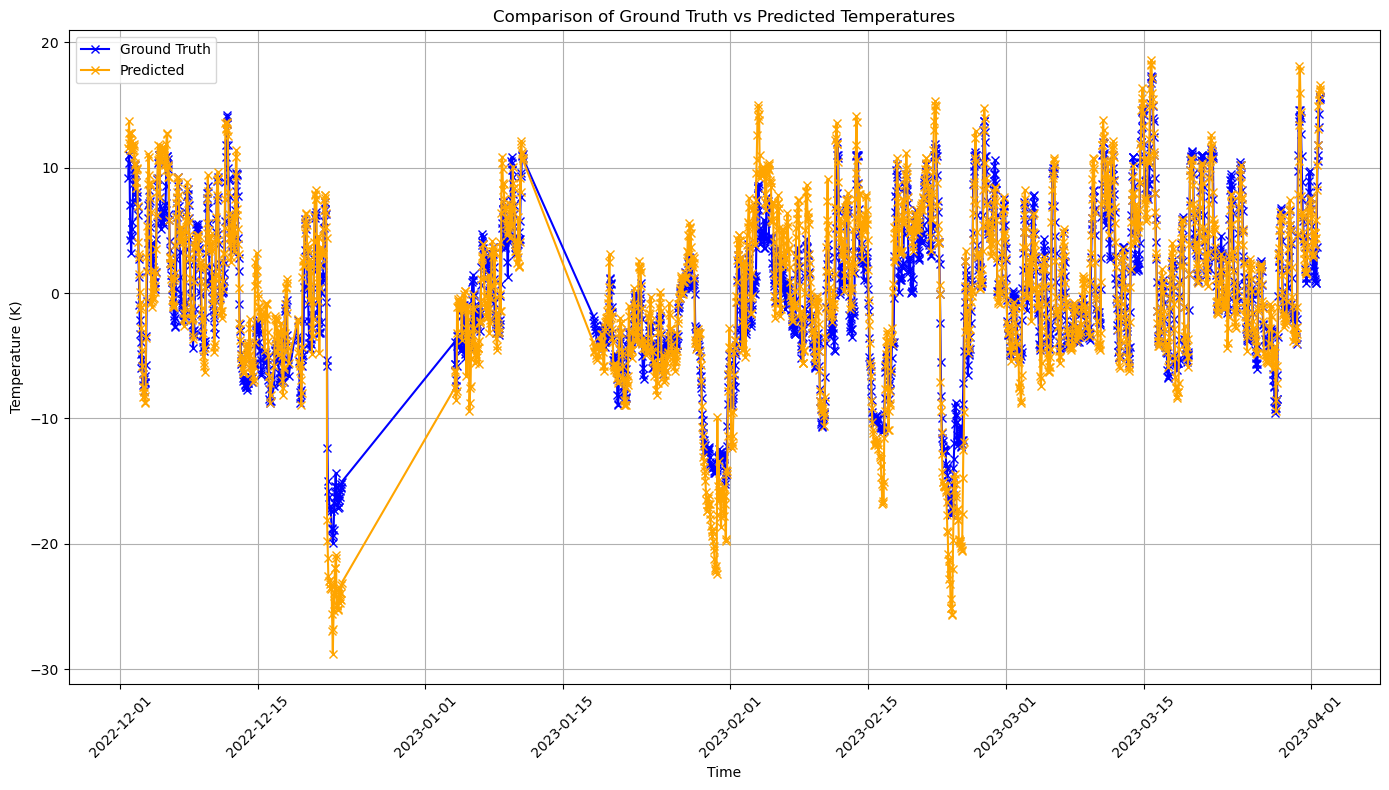

In [72]:
def improved_plot_datasets(ds1: xr.DataArray, ds2: xr.DataArray, title1="Ground Truth", title2="Predicted"):
    """
    Improved plot for two xarray DataArrays over time, with enhancements.

    Parameters:
    ds1 (xr.DataArray): First DataArray to plot.
    ds2 (xr.DataArray): Second DataArray to plot.
    title1 (str): Label for the first dataset.
    title2 (str): Label for the second dataset.
    """
    # Align datasets to ensure they share the same time axis
    ds1, ds2 = xr.align(ds1, ds2)

    # Create a larger figure
    plt.figure(figsize=(14, 8))

    # Plot each dataset with markers and handle missing values (NaN)
    plt.plot(ds1.time, ds1.where(~ds1.isnull()), label=title1, marker='x', linestyle='-', color='blue')
    plt.plot(ds2.time, ds2.where(~ds2.isnull()), label=title2, marker='x', linestyle='-', color='orange')

    # Adding labels, title, and legend
    plt.xlabel('Time')
    plt.ylabel('Temperature (K)')
    plt.title('Comparison of Ground Truth vs Predicted Temperatures')
    plt.legend()

    # Rotate x-axis labels and add grid for better readability
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Usage
improved_plot_datasets(aggregated_output_output.mean_t2m, aggregated_output_gt.mean_t2m)


In [73]:
# Example usage
metrics = calculate_metrics(aggregated_output_output.mean_t2m, aggregated_output_gt.mean_t2m , var="temperature", output_path="executed_trainings/Marshall_t2m_20241113-18/model/metrics_results.txt")



In [74]:
print(metrics)


{'R^2': 0.8101894007426861, 'RMSE': 2.758622, 'Pearson Correlation': 0.9378727505079539}
